# **Proyek Klasifikasi Gambar Ilmiah Multi-Kelas dengan Transfer Learning**

- Dataset: Scientific Image Dataset
- Sumber: https://www.kaggle.com/datasets/rushilprajapati/data-final
- Tujuan:
Membangun, melatih, dan mengevaluasi model Convolutional Neural Network (CNN) untuk mengklasifikasikan gambar ilmiah ke dalam 6 kategori (Blot-Gel, FACS, Histopathology, Macroscopy, Microscopy, Non-scientific)

---

## **1. SETUP & IMPORT LIBRARIES**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import pathlib
import random
import PIL
import shutil

# Konfigurasi Dasar
print("Versi TensorFlow:", tf.__version__)

# Menonaktifkan pesan log TensorFlow yang kurang penting
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Definisikan Konstanta & Path
DATASET_DIR = pathlib.Path('data/')
if not DATASET_DIR.exists():
    raise FileNotFoundError(f"Direktori dataset tidak ditemukan di: {DATASET_DIR}\n"
                          "Pastikan dataset sudah diunduh dan diletakkan di path yang benar.")

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 100
EPOCHS = 30     
LEARNING_RATE = 1e-4
SEED = 42

# Set seed untuk reproduktifitas
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

Versi TensorFlow: 2.10.0


## **2. EKSPLORATORY DATA ANALYSIS (EDA)**

In [2]:
print("\n--- Memulai Eksploratory Data Analysis (EDA) ---")

# Identifikasi Kelas
class_names = sorted([item.name for item in DATASET_DIR.glob('*') if item.is_dir()])
num_classes = len(class_names)
print(f"Jumlah Kelas Ditemukan: {num_classes}")
print(f"Nama Kelas: {class_names}")


--- Memulai Eksploratory Data Analysis (EDA) ---
Jumlah Kelas Ditemukan: 6
Nama Kelas: ['Blot-Gel', 'FACS', 'Histopathology', 'Macroscopy', 'Microscopy', 'Non-scientific']


In [3]:
# Hitung Jumlah Gambar per Kelas
print("\nDistribusi Data per Kelas:")
class_distribution = {}
total_images = 0
for class_name in class_names:
    class_dir = DATASET_DIR / class_name
    count = len(list(class_dir.glob('*.[jp][pn]g'))) # Menghitung jpg dan png
    class_distribution[class_name] = count
    total_images += count
    print(f"- {class_name}: {count} gambar")
print(f"Total Gambar: {total_images}")


Distribusi Data per Kelas:
- Blot-Gel: 1875 gambar
- FACS: 1070 gambar
- Histopathology: 5179 gambar
- Macroscopy: 4401 gambar
- Microscopy: 1509 gambar
- Non-scientific: 5010 gambar
Total Gambar: 19044


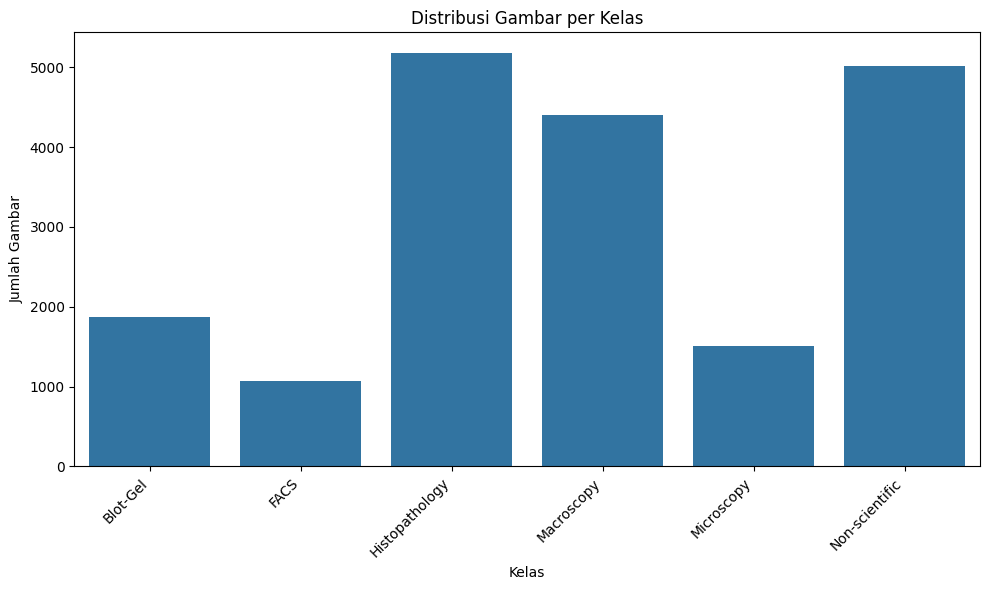

In [4]:
# Visualisasi Distribusi Data
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('Distribusi Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Menampilkan Sampel Gambar Acak:


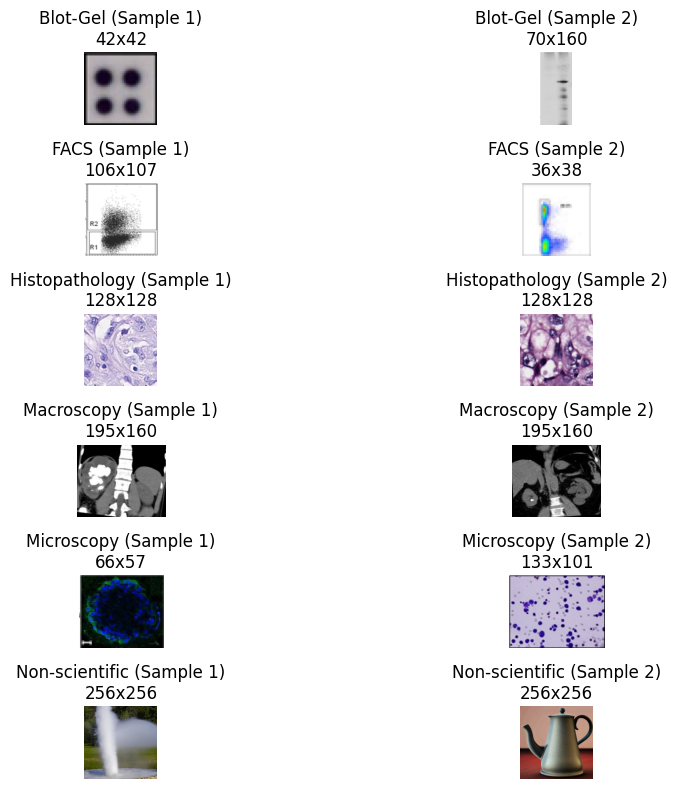

In [5]:
# Tampilkan Sampel Gambar Acak dari Setiap Kelas (2 per kelas)

# Fungsi untuk menghitung ukuran baru dengan mempertahankan rasio aspek
def calculate_scaled_size(original_size, scale_factor=0.5):
    return (int(original_size[0] * scale_factor), int(original_size[1] * scale_factor))

print("\nMenampilkan Sampel Gambar Acak:")
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    class_dir = DATASET_DIR / class_name
    image_files = list(class_dir.glob('*.[jp][pn]g'))
    
    if len(image_files) >= 2:
        sample_images = random.sample(image_files, 2)
        for j, img_path in enumerate(sample_images):
            # Buka gambar dan dapatkan ukuran asli
            original_img = PIL.Image.open(img_path)
            original_size = original_img.size
            
            # Hitung ukuran baru dengan skala 50%
            scaled_size = calculate_scaled_size(original_size, scale_factor=0.5)
            
            # Resize dengan mempertahankan rasio aspek
            img = original_img.resize(scaled_size)
            
            # Tampilkan gambar
            plt.subplot(num_classes, 2, i * 2 + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name} (Sample {j+1})\n{scaled_size[0]}x{scaled_size[1]}")
            plt.axis('off')
            
    elif len(image_files) == 1:
        img_path = image_files[0]
        original_img = PIL.Image.open(img_path)
        original_size = original_img.size
        scaled_size = calculate_scaled_size(original_size, scale_factor=0.5)
        img = original_img.resize(scaled_size)
        
        plt.subplot(num_classes, 2, i * 2 + 1)
        plt.imshow(img)
        plt.title(f"{class_name} (Sample 1)\n{scaled_size[0]}x{scaled_size[1]}")
        plt.axis('off')

plt.tight_layout()
plt.show()

## **3. SAMPLING DATA**

In [6]:
# Kelas yang akan disampling dan ukuran samplingnya
SAMPLED_DATASET_DIR = pathlib.Path('/data_sampled') # Path untuk dataset hasil sampling
CLASSES_TO_SAMPLE = ["Histopathology", "Macroscopy", "Non-scientific"]
SAMPLE_SIZE = 2000

In [ ]:
print("\n--- Memulai Sampling Data ---")

# Hapus direktori sampling lama jika ada, untuk memastikan kebersihan
if SAMPLED_DATASET_DIR.exists():
    print(f"Menghapus direktori sampling lama: {SAMPLED_DATASET_DIR}")
    shutil.rmtree(SAMPLED_DATASET_DIR)

print(f"Membuat direktori baru untuk data hasil sampling: {SAMPLED_DATASET_DIR}")
SAMPLED_DATASET_DIR.mkdir(parents=True, exist_ok=True)

# Identifikasi semua kelas di dataset asli
original_class_names = sorted([item.name for item in DATASET_DIR.glob('*') if item.is_dir()])
print(f"Kelas yang ditemukan di dataset asli: {original_class_names}")

total_copied_files = 0
for class_name in original_class_names:
    original_class_path = DATASET_DIR / class_name
    sampled_class_path = SAMPLED_DATASET_DIR / class_name
    sampled_class_path.mkdir(exist_ok=True) # Buat subdirektori kelas di tujuan

    all_files = list(original_class_path.glob('*.[jp][pn]g')) # Cari file jpg & png

    if class_name in CLASSES_TO_SAMPLE:
        print(f"Melakukan sampling pada kelas '{class_name}'...")
        if len(all_files) <= SAMPLE_SIZE:
            print(f"  Jumlah file ({len(all_files)}) <= target ({SAMPLE_SIZE}). Menyalin semua file.")
            files_to_copy = all_files
        else:
            print(f"  Mengambil {SAMPLE_SIZE} sampel acak dari {len(all_files)} file.")
            files_to_copy = random.sample(all_files, SAMPLE_SIZE)
    else:
        print(f"Menyalin semua file dari kelas '{class_name}' (tidak disampling)...")
        files_to_copy = all_files

    # Salin file yang dipilih ke direktori baru
    copied_count = 0
    for f_path in files_to_copy:
        try:
            shutil.copy2(f_path, sampled_class_path / f_path.name) # copy2 mempertahankan metadata
            copied_count += 1
        except Exception as e:
            print(f"  Gagal menyalin {f_path.name}: {e}")

    print(f"  {copied_count} file disalin untuk kelas '{class_name}'.")
    total_copied_files += copied_count

print(f"\nTotal file yang disalin ke {SAMPLED_DATASET_DIR}: {total_copied_files}")
print("Sampling data selesai.")

# !!! PENTING: Update DATASET_DIR untuk menunjuk ke data hasil sampling !!!
DATASET_DIR = SAMPLED_DATASET_DIR


--- Memulai Sampling Data ---
Menghapus direktori sampling lama: \data_sampled
Membuat direktori baru untuk data hasil sampling: \data_sampled
Kelas yang ditemukan di dataset asli: ['Blot-Gel', 'FACS', 'Histopathology', 'Macroscopy', 'Microscopy', 'Non-scientific']
Menyalin semua file dari kelas 'Blot-Gel' (tidak disampling)...
  1875 file disalin untuk kelas 'Blot-Gel'.
Menyalin semua file dari kelas 'FACS' (tidak disampling)...
  1070 file disalin untuk kelas 'FACS'.
Melakukan sampling pada kelas 'Histopathology'...
  Mengambil 2000 sampel acak dari 5179 file.
  2000 file disalin untuk kelas 'Histopathology'.
Melakukan sampling pada kelas 'Macroscopy'...
  Mengambil 2000 sampel acak dari 4401 file.
  2000 file disalin untuk kelas 'Macroscopy'.
Menyalin semua file dari kelas 'Microscopy' (tidak disampling)...



Distribusi Data per Kelas (setelah sampling):
- Blot-Gel: 1875 gambar
- FACS: 1070 gambar
- Histopathology: 2000 gambar
- Macroscopy: 2000 gambar
- Microscopy: 1509 gambar
- Non-scientific: 2000 gambar
Total Gambar (setelah sampling): 10454


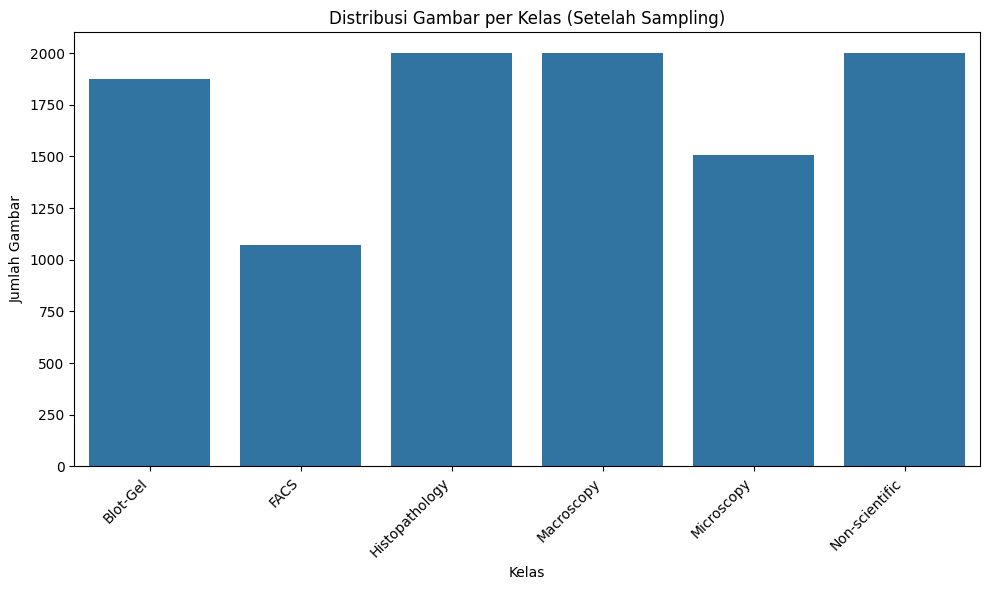

In [ ]:
# Hitung Jumlah Gambar per Kelas (dari direktori hasil sampling)
print("\nDistribusi Data per Kelas (setelah sampling):")
class_distribution = {}
total_images = 0
for class_name in class_names:
    class_dir = DATASET_DIR / class_name
    count = len(list(class_dir.glob('*.[jp][pn]g')))
    class_distribution[class_name] = count
    total_images += count
    print(f"- {class_name}: {count} gambar")
print(f"Total Gambar (setelah sampling): {total_images}")

# Visualisasi Distribusi Data (setelah sampling)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('Distribusi Gambar per Kelas (Setelah Sampling)')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **4. DATA PREPROCESSING & SPLITTING**

In [ ]:
print("\n--- Memulai Preprocessing dan Pemisahan Data ---")
# Load dataset awal (sebelum split)
# Catatan: image_dataset_from_directory secara otomatis menginferensi label dari nama direktori
initial_dataset = image_dataset_from_directory(
    DATASET_DIR,
    labels='inferred',
    label_mode='int', # Karena kita pakai SparseCategoricalCrossentropy
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=True, # Penting untuk mengacak data
    seed=SEED
)


--- Memulai Preprocessing dan Pemisahan Data ---
Found 10454 files belonging to 6 classes.


In [ ]:
# Tentukan ukuran set
dataset_size = tf.data.experimental.cardinality(initial_dataset).numpy() * BATCH_SIZE
train_size = int(0.7 * dataset_size)
val_test_size = dataset_size - train_size
val_size = int(0.5 * val_test_size)
test_size = val_test_size - val_size

print(f"Total data: {dataset_size}")
print(f"Ukuran Train Set: ~{train_size}")
print(f"Ukuran Validation Set: ~{val_size}")
print(f"Ukuran Test Set: ~{test_size}")

Total data: 10500
Ukuran Train Set: ~7349
Ukuran Validation Set: ~1575
Ukuran Test Set: ~1576


In [ ]:
# Fungsi untuk split manual (karena validation_split hanya membagi 2)
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000, seed=None):
    assert (train_split + val_split + test_split) == 1

    ds_size = tf.data.experimental.cardinality(ds)
    if isinstance(ds_size, tf.Tensor) and ds_size.numpy() == tf.data.experimental.UNKNOWN_CARDINALITY:
        # Estimasi jika cardinality tidak diketahui (kurang ideal, tapi perlu fallback)
        print("WARNING: Dataset cardinality is unknown. Estimating size. Split might be approximate.")
        # Hitung ulang manual (bisa lambat untuk dataset besar)
        count = 0
        for _ in ds.unbatch():
            count += 1
        ds_size = count
    else:
        ds_size = ds_size.numpy() * BATCH_SIZE # Perkiraan jika pakai batch size

    if shuffle:
        # Pastikan seed diset untuk reproduktifitas shuffle
        ds = ds.shuffle(shuffle_size, seed=seed)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # Unbatch dulu agar split lebih akurat per sampel
    ds = ds.unbatch()

    train_ds = ds.take(train_size)
    val_test_ds = ds.skip(train_size)
    val_ds = val_test_ds.take(val_size)
    test_ds = val_test_ds.skip(val_size)

    # Re-batch dataset setelah split
    train_ds = train_ds.batch(BATCH_SIZE)
    val_ds = val_ds.batch(BATCH_SIZE)
    test_ds = test_ds.batch(BATCH_SIZE)

    return train_ds, val_ds, test_ds

In [ ]:
# Melakukan splitting
# Muat ulang dataset tanpa shuffle awal agar split konsisten, lalu shuffle di fungsi split
initial_dataset_no_shuffle = image_dataset_from_directory(
    DATASET_DIR,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE, # Load dengan batch size agar cardinality bisa dihitung
    shuffle=False # Jangan shuffle di sini
)

train_ds, val_ds, test_ds = get_dataset_partitions_tf(initial_dataset_no_shuffle, seed=SEED)

print(f"\nJumlah batch Train Set: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Jumlah batch Validation Set: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Jumlah batch Test Set: {tf.data.experimental.cardinality(test_ds).numpy()}")

# Verifikasi satu batch data
for images, labels in train_ds.take(1):
    print("\nBentuk batch gambar (Train):", images.shape)
    print("Bentuk batch label (Train):", labels.shape)
    print("Contoh label:", labels.numpy()[:5])

Found 10454 files belonging to 6 classes.

Jumlah batch Train Set: -2
Jumlah batch Validation Set: -2
Jumlah batch Test Set: -2

Bentuk batch gambar (Train): (100, 224, 224, 3)
Bentuk batch label (Train): (100,)
Contoh label: [0 0 0 0 0]


## **5. DATA AUGMENTATION & PIPELINE OPTIMIZATION**

In [ ]:
print("\n--- Konfigurasi Augmentasi Data dan Optimalisasi Pipeline ---")

# Layer Augmentasi Data (akan dimasukkan ke dalam model)
# Ini memastikan augmentasi hanya terjadi saat training dan tidak pada validasi/test
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        layers.Rescaling(1./255)
    ],
    name="data_augmentation",
)

rescale_layer = layers.Rescaling(1./255, name="rescaling_block")


--- Konfigurasi Augmentasi Data dan Optimalisasi Pipeline ---


In [ ]:
# Layer Rescaling (Normalisasi) - Penting untuk model pre-trained
# Model pre-trained biasanya mengharapkan input piksel dalam rentang [-1, 1] atau [0, 1]
# EfficientNet mengharapkan piksel [0, 255] (preprocessing sudah built-in, tapi mari kita eksplisit)
# Jika menggunakan model lain (misal ResNet, MobileNet), rescaling ke [-1, 1] atau [0, 1] mungkin diperlukan.
# Untuk EfficientNet, kita bisa skip rescaling manual atau gunakan rescale=1./255 jika preprocessingnya tidak aktif.
# Kita akan letakkan rescaling sebelum base model dalam arsitektur.
# rescale_layer = layers.Rescaling(1./255) # Contoh jika perlu [0,1]
# rescale_layer = layers.Rescaling(1./127.5, offset=-1) # Contoh jika perlu [-1,1]

# Optimasi Pipeline Data: Prefetching dan Caching
# Cache: Menyimpan data di memori setelah load/augmentasi pertama (jika muat di RAM)
# Prefetch: Mempersiapkan batch data berikutnya selagi model training di batch saat ini
AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
    ds = ds.cache() # Cache dataset (jika muat di memori)
    ds = ds.shuffle(buffer_size=1000) # Shuffle ulang setiap epoch jika diperlukan (sudah dishuffle saat split)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

print("Pipeline data dikonfigurasi untuk performa.")

Pipeline data dikonfigurasi untuk performa.


## **6. MODEL BUILDING (TRANSFER LEARNING)**

In [ ]:
print("\n--- Membangun Model CNN dengan Transfer Learning ---")

# Memuat Base Model Pre-trained (EfficientNetB0)
# include_top=False: Menghilangkan layer klasifikasi akhir dari model pre-trained
# weights='imagenet': Menggunakan bobot yang sudah dilatih di ImageNet
# input_shape: Harus sesuai dengan ukuran gambar kita
# base_model = EfficientNetV2B0(include_top=False,
#                             weights='imagenet',
#                             input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
#                             pooling=None) # Kita akan tambahkan pooling layer sendiri
base_model = MobileNetV2(include_top=False,
                            weights='imagenet',
                            input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                            ) 

# Membekukan bobot base model (agar tidak ikut terlatih di awal)
base_model.trainable = False
print(f"Jumlah layer di base model: {len(base_model.layers)}")
print(f"Base model trainable: {base_model.trainable}")


--- Membangun Model CNN dengan Transfer Learning ---
Jumlah layer di base model: 154
Base model trainable: False


In [ ]:
# Membangun Model Sequential di atas Base Model
model = Sequential([
    # 1. Input Layer (implisit, tapi kita definisikan shape di augmentation)
    data_augmentation, # Terapkan augmentasi sebagai bagian dari model

    # 3. Base Model Pre-trained (Frozen)
    base_model,
    
    # 4. Feature Enhancement

    layers.Conv2D(128, (3,3), activation='swish', padding='same', name="conv_1"),  # 1x1 Conv
    layers.MaxPooling2D(2,2),
    layers.GlobalAveragePooling2D(name="global_avg_pool"), # Mengubah output fitur menjadi vektor flat

    # 5. Layer Tambahan untuk Klasifikasi (Head)
    layers.BatchNormalization(name="batch_norm_2"), # Menstabilkan & mempercepat training
    layers.Dropout(0.3, name="dropout_1"),          # Regularisasi untuk mengurangi overfitting
    layers.Dense(256, activation='swish', name="dense_1"),
    layers.BatchNormalization(name="batch_norm_3"),
    layers.Dropout(0.3, name="dropout_2"),
    layers.Dense(num_classes, activation='softmax', name="output_layer") # Output layer (sesuai jumlah kelas)
], name="ScientificImageClassifier")

In [ ]:
# Compile Model
# Optimizer: Adam adalah pilihan yang solid
# Loss: SparseCategoricalCrossentropy karena label kita integer (dari image_dataset_from_directory)
# Metrics: Akurasi
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Tampilkan Ringkasan Model
model.summary()

Model: "ScientificImageClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv_1 (Conv2D)             (None, 7, 7, 128)         1474688   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 128)        0         
 )                                                               
                                                                 
 global_avg_pool (GlobalAver  (None, 128)              0         
 agePooling2D)                           

## **7. CALLBACKS**

In [ ]:
print("\n--- Mengkonfigurasi Callbacks ---")

# ModelCheckpoint: Menyimpan model terbaik selama training
checkpoint_path = "best_model_checkpoint.h5" # Atau .keras format baru
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False, # Simpan seluruh model
    monitor='val_accuracy',  # Monitor akurasi validasi
    mode='max',              # Simpan model dengan akurasi validasi tertinggi
    save_best_only=True,     # Hanya simpan yang terbaik
    verbose=1
)

# EarlyStopping: Menghentikan training jika tidak ada peningkatan
early_stopping_callback = EarlyStopping(
    monitor='val_loss',      # Monitor loss validasi
    patience=3,              # Jumlah epoch tanpa peningkatan sebelum berhenti (sesuaikan)
    verbose=1,
    restore_best_weights=True # Kembalikan bobot terbaik saat berhenti
)

# ReduceLROnPlateau: Mengurangi learning rate jika performa stagnan
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1, # Faktor pengurangan LR (new_lr = lr * factor)
    patience=1, # Jumlah epoch tanpa peningkatan loss sebelum LR dikurangi
    min_lr=1e-6, # Batas bawah learning rate
    verbose=1
)

callbacks_list = [model_checkpoint_callback, early_stopping_callback, reduce_lr_callback]


--- Mengkonfigurasi Callbacks ---


## **8. MODEL TRAINING**

In [ ]:
print("\n--- Memulai Training Model ---")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

print("Training selesai.")

# Opsional: Fine-tuning (jika diperlukan setelah training awal)
# 1. Unfreeze beberapa layer teratas dari base model
# base_model.trainable = True
# fine_tune_at = 100 # Contoh: Unfreeze dari layer ke-100 ke atas
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False
# 2. Re-compile model dengan learning rate yang SANGAT KECIL
# optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE / 100) # LR lebih kecil
# model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# 3. Lanjutkan training untuk beberapa epoch lagi
# history_fine = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS + 10, initial_epoch=history.epoch[-1], callbacks=callbacks_list)
# print("Fine-tuning selesai.")
# Catatan: Jika melakukan fine-tuning, plot dan evaluasi akhir harus menggunakan history gabungan atau history_fine.


--- Memulai Training Model ---
Epoch 1/30
      7/Unknown - 37s 4s/step - loss: 2.7321 - accuracy: 0.1571